In [1]:
import os
import itertools 
from copy import deepcopy
from collections import OrderedDict
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm


How does one do gridsearch CV on DBSCAN?
- eps is rather simple since we know the extent of the map and how far away a ward can see. Even if sentry and observer have different vision capacity, it shouldn't make much of a difference.
- min_samples is another story. Arbitrarily let's say no cluster can have more than 25% of all samples. Let's say lowest min_samples is 5 and at every iteration we increase by 10% of the max (0.1*0.25=0.025).

In [2]:
class WardFinder:
    def __init__(self, 
                 obs_data_path: str, 
                 sen_data_path: str, 
                 map_img: str = 'maps/map_detailed_723.jpeg',
                 exclude_pregame: bool =False):
        
        
        """Inits WardFinder with observer and sentry data"""
        #load the data
        self.obs_data = pd.read_csv(obs_data_path)
        self.sen_data = pd.read_csv(sen_data_path)
        self.map_img = Image.open(map_img)
        
        #exclude pregame if required
        if exclude_pregame:
            self.obs_data = self.obs_data[self.obs_data['time']>=0]
            self.sen_data = self.sen_data[self.sen_data['time']>=0]
            
        
        
        #check we have same columns for both
        if all(self.obs_data.columns != self.sen_data.columns):
            raise ValueError("columns of observer and sentry data must be identical")
        
        
        #translate lower left corner translated (64,64)-->(0,0) 
        self.obs_data['x'] = self.obs_data['x'] - 64
        self.obs_data['y'] = self.obs_data['y'] - 64
        self.sen_data['x'] = self.sen_data['x'] - 64
        self.sen_data['y'] = self.sen_data['y'] - 64
        
        #get the columns associated with a building dire/radiant
        self._bldg_cols = [col for col in self.obs_data.columns
                          if ('dire_' in col)
                          or ('radiant_' in col)]
        
        #max time possible for a match
        #make sure time  is in seconds for both obs_data and sen_data
        self._MAX_TIME_POSSIBLE= 3*60*60
        #fill nans
        self.obs_data[self._bldg_cols] = self.obs_data[self._bldg_cols].fillna(value=self._MAX_TIME_POSSIBLE)
        self.sen_data[self._bldg_cols] = self.sen_data[self._bldg_cols].fillna(value=self._MAX_TIME_POSSIBLE)
        
        #create the filtered dataframe
        self.obs_data_filter = self.obs_data.copy(deep=True)
        self.sen_data_filter = self.sen_data.copy(deep=True)
        
        
        
        #at start all towers are alive
        # prefer not to modify this dict except if location of towers changes
        self._TOWER_DICT = OrderedDict({
            'dire_fort': 
            {'x': 110, 'y': 107.5, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower1_bot': 
            {'x': 111.5, 'y': 47.4, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower1_mid': 
            {'x': 65.2, 'y': 66.3, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower1_top': 
            {'x': 22.8, 'y': 109.6, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower2_bot': 
            {'x': 110.5, 'y': 66.7, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower2_mid': 
            {'x': 84.4, 'y': 81.9, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower2_top': 
            {'x': 59.8, 'y': 111.2, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower3_bot': 
            {'x': 112.5, 'y': 88.2, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower3_mid': 
            {'x': 95.9 , 'y': 92.4, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower3_top': 
            {'x': 92, 'y': 108.2, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower4_left': 
            {'x': 104.9, 'y': 104, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'dire_tower4_right': 
            {'x': 110, 'y': 102, 'is_alive':1, 'color': 'red', 'alive_at_rosh' : 1.0},
            'radiant_fort': 
            {'x': 14.1, 'y': 18.5, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower1_bot': 
            {'x': 103.5, 'y': 17.9, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower1_mid': 
            {'x': 51.1, 'y': 55.4, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower1_top': 
            {'x': 13.8, 'y': 76.6, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower2_bot': 
            {'x': 62.2, 'y': 15.4, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower2_mid': 
            {'x': 38.3, 'y': 44.9, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower2_top': 
            {'x': 13.8, 'y': 59.1, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower3_bot': 
            {'x': 31.7, 'y': 17, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower3_mid': 
            {'x': 24.4, 'y': 30.3, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower3_top': 
            {'x': 11.5, 'y': 37.2, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0},
            'radiant_tower4_left': 
            {'x': 13.7, 'y': 24.1, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0}, 
            'radiant_tower4_right': 
            {'x': 18.9, 'y': 19.4, 'is_alive':1, 'color': 'lime', 'alive_at_rosh' : 1.0}
        })
        
        
        #vision radius of observer/sentry
        self._RADIUS_OBSERVER = 8.96
        self._RADIUS_SENTRY = 5.76
        
        #color scheme
        self._SEN_RAD_COLOR = 'blue'
        self._SEN_DIR_COLOR = 'gold'
        self._OBS_RAD_COLOR = 'lime'
        self._OBS_DIR_COLOR = 'red'
        
        
        #legend scheme
        self._SEN_RAD_PACTH = patches.Patch(color=self._SEN_RAD_COLOR,
                                            label='Radiant Sentry') 
        self._SEN_DIR_PATCH = patches.Patch(color=self._SEN_DIR_COLOR,
                                            label='Dire Sentry') 
        self._OBS_RAD_PATCH = patches.Patch(color=self._OBS_RAD_COLOR,
                                            label='Radiant Observer') 
        self._OBS_DIR_PACTH = patches.Patch(color=self._OBS_DIR_COLOR,
                                            label='Dire Observer') 
        
        #put inside one handles
        self._LEGEND_HANDLE = [self._SEN_RAD_PACTH,
                               self._SEN_DIR_PATCH, 
                               self._OBS_RAD_PATCH,
                               self._OBS_DIR_PACTH]
        
        
        #rectangle width and height
        self._RECT_H = self._RECT_W = 4
        
        #minimum number of rows allowed
        self._MIN_ROWS_ALLOWABLE = 50
        
        #line width to use in plotting towers
        self._LINE_W = 2
        
            
    def _filter_by_tower(self, 
                        df: pd.core.frame.DataFrame,
                        is_radiant: bool =True,
                        lane : str ='top', 
                        tower_number : int =0):
        """
        Returns dataframe where given tower is alive based on user criteria
        Parameters
        ----------
        df: pandas
            Dataframe containing data.
        
        is_radiant: Bool, default=True
                    True if Radiant and False if Dire.
                    
        lane: string, default='top'
              The lane, can only be ('top', 'mid', 'bot')  
        
        tower_num: integer, default= 0
                   The tower number that was most recently taken. Can only be 0,1,2,3 such that zero means no objectives were taken. 
                   1 means that tower 1 is taken, etc...
        
        
        """

        

        #check for input on tower number
        if not (0 <= tower_number <= 3):
            raise ValueError('The number entered can only be (0,1,2,3)')
        #check for input on lane
        if lane not in ('top', 'mid', 'bot'):
            raise ValueError('Only allowed inputs are ("top", "mid", "bot")')
            
        
        #prepare query column
        if is_radiant:
            side = 'radiant_tower'
        else:
            side = 'dire_tower'
        
        
        #if tower tower number is 0 then tower is alive at time of planting
        if tower_number == 0:
            col = ''.join([side,
                           '1',
                           '_', 
                           lane]
                         )
            #return wards planted BEFORE death of corresponding tier 1 tower
            return df.query(f'time < {col}')
        
        
        # UPDATE TOWER DICT OTHERWISE
        for number in np.arange(1, tower_number+1, 1):
            key = ''.join([side,
                               str(number),
                               '_', 
                               lane]
                         )
            self._TOWER_DICT[key]['is_alive'] = 0
            self._TOWER_DICT[key]['color'] = 'grey'
        
        
        #if tower number less than 3 get times in between
        if tower_number <3:
            col_lower = ''.join([side,
                           str(tower_number),
                           '_', 
                           lane]
                         )
            
            col_upper = ''.join([side,
                           str(tower_number+1),
                           '_', 
                           lane]
                         )
            
            
            #wards planted AFTER death of col but BEFORE death of next tower
            return df.query(f'{col_lower} < time < {col_upper}')
        
        
        #if equal to three than just get everything after
        col = ''.join([side,
                       str(tower_number),
                       '_', 
                       lane]
                     )
        
        #return wards planted after death of building
        return df.query(f'time > {col}')
        
        
    def _reset_tower_dict(self):
        """
        resets _TOWER_DICT key is_alive to 1
        """
        #reset tower dict
        for key in self._TOWER_DICT.keys():
            self._TOWER_DICT[key]['is_alive'] = 1
            self._TOWER_DICT[key]['alive_at_rosh'] = 1.0
            if 'radiant' in key:
                self._TOWER_DICT[key]['color'] = 'lime'
            else:
                self._TOWER_DICT[key]['color'] = 'red'
    
    
    
    def get_filtered_wards(self, 
                        radiant_top: int =0, 
                        radiant_mid: int =0, 
                        radiant_bot: int =0, 
                        dire_top: int =0, 
                        dire_mid: int =0, 
                        dire_bot: int =0
                          ):
        """
        modifies filter dataframe for last surviving tier tower in all lanes. 
        Let 0 denote that the tower is still alive. Any number greater than 0 means that this tower is destroyed.
        ----------
        radiant_top: integer, default=0
                    Last destroyed tower in radiant top lane
        radiant_mid: integer, default=0
                    Last destroyed tower in radiant mid lane
        radiant_bot: integer, default=0
                    Last destroyed tower in radiant bot lane
        dire_top: integer, default=0
                    Last destroyed tower in dire top lane
        dire_mid: integer, default=0
                    Last destroyed tower in dire mid lane
        dire_bot: integer, default=0
                    Last destroyed tower in dire bot lane
    
        """
        
        
        #reset tower dict
        self._reset_tower_dict()
        
#         for key in self._TOWER_DICT.keys():
#             self._TOWER_DICT[key]['is_alive'] = 1
#             if 'radiant' in key:
#                 self._TOWER_DICT[key]['color'] = 'lime'
#             else:
#                 self._TOWER_DICT[key]['color'] = 'red'
            
        
        #make a deep copy of existing original df
        df_filter = self.obs_data.copy(deep=True)

        #for radiant top towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=True,
                                         lane='top',
                                         tower_number = radiant_top)
        #for radiant mid towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=True,
                                         lane='mid',
                                         tower_number = radiant_mid)
        #for radiant bot towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=True,
                                         lane='bot',
                                         tower_number = radiant_bot)
        #for dire top towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=False,
                                         lane='top',
                                         tower_number = dire_top)
        #for dire mid towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=False,
                                         lane='mid',
                                         tower_number = dire_mid)
        #for dire bot towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=False,
                                         lane='bot',
                                         tower_number = dire_bot)
        
        #make sure to always deep copy to avoid circular references
        self.obs_data_filter = df_filter.copy(deep=True)
        

        
        ## REPEAT FOR SENTRY  ##
        df_filter = self.sen_data.copy(deep=True)

        
        #for radiant top towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=True,
                                         lane='top',
                                         tower_number = radiant_top)
        #for radiant mid towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=True,
                                         lane='mid',
                                         tower_number = radiant_mid)
        #for radiant bot towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=True,
                                         lane='bot',
                                         tower_number = radiant_bot)
        #for dire top towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=False,
                                         lane='top',
                                         tower_number = dire_top)
        #for dire mid towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=False,
                                         lane='mid',
                                         tower_number = dire_mid)
        #for dire bot towers
        df_filter = self._filter_by_tower(df = df_filter, 
                                         is_radiant=False,
                                         lane='bot',
                                         tower_number = dire_bot)
        
        
        self.sen_data_filter = df_filter.copy(deep=True)
        
        #clear up some memory
        del df_filter
        
# START WORK AFTER THIS LINE START WORK AFTER THIS LINE START WORK AFTER THIS LINE START WORK AFTER THIS LINE ##       
        
    def _gridsearch_clusters(self, df):
        """
        performs gridsearch cv on (x,y) columns of a dataframe and returns best params
        """
        #define list of epsilon values
        eps_space = np.arange(2, 6.5, 0.5)

        #assume that max samples is 25% of dataset
        samples_max = df.shape[0]//4

        #create sample space
        sample_space = np.arange(5, samples_max, samples_max//5)
        
        #prepare to check for best score
        best_score = -1
        dbscan_best = None

        #store results here
        for eps in eps_space:
            for samples in sample_space:
                #init dbscan with params
                db = DBSCAN(eps=eps, min_samples=samples)
                #fit to columns
                db.fit(df[['x', 'y']])
                #silhouette score won't work with less than 2 labels
                if len(set(db.labels_)) >= 2:
                    score = silhouette_score(df[['x', 'y']], labels=db.labels_)
                else:
                    score= -1

                #if better than previous secore
                if score > best_score:
                    #update the newest score
                    best_score = score
                    
                    dbscan_best = deepcopy(db)
                    
        return dbscan_best

        

    def _compute_xy_centroid_pairs(self, df, dbscan):
        """
        computes centroid pairs for 2-dimensional data
        """
        
        #get unique labels from clustering algo
        labels_unique = np.unique(dbscan.labels_)
        db_labels = dbscan.labels_
        
        centroid_pairs = []

        for label in labels_unique:
            #places where label matches
            label_arg = np.argwhere(db_labels==label).ravel()
            #reduced version of where labels occur
            df_label_cluster = df.iloc[label_arg]
            #getting pairs
            x_centroid = df_label_cluster['x'].mean()
            y_centroid = df_label_cluster['y'].mean()
            centroid_pairs.append((x_centroid, y_centroid))
            
        return centroid_pairs
    
    
    def fit_clusters(self):
        """
        finds best DBSCAN for observer/sentry and radiant/dire.
        """
        #sentry data
        self.sen_data_rad = self.sen_data_filter[self.sen_data_filter['is_radiant']==1]
        self.sen_data_dir = self.sen_data_filter[self.sen_data_filter['is_radiant']==0]
        #obsever data
        self.obs_data_rad = self.obs_data_filter[self.obs_data_filter['is_radiant']==1]
        self.obs_data_dir = self.obs_data_filter[self.obs_data_filter['is_radiant']==0]
        
        #store number of rows in data
        shape_list = [self.sen_data_rad.shape[0], 
                      self.sen_data_dir.shape[0], 
                      self.obs_data_rad.shape[0], 
                      self.obs_data_dir.shape[0]]
        
        #check we have at least the mininum number of entries
        if all(n_rows > self._MIN_ROWS_ALLOWABLE for n_rows in shape_list):

            #get dbscan for each sub division 
            self.sen_rad_db = self._gridsearch_clusters(self.sen_data_rad)
            self.sen_dir_db = self._gridsearch_clusters(self.sen_data_dir)
            self.obs_rad_db = self._gridsearch_clusters(self.obs_data_rad)
            self.obs_dir_db = self._gridsearch_clusters(self.obs_data_dir)

            #calculate clusters
            self.sen_rad_centroids = self._compute_xy_centroid_pairs(self.sen_data_rad, self.sen_rad_db)
            self.sen_dir_centroids = self._compute_xy_centroid_pairs(self.sen_data_dir, self.sen_dir_db)
            self.obs_rad_centroids = self._compute_xy_centroid_pairs(self.obs_data_rad, self.obs_rad_db)
            self.obs_dir_centroids = self._compute_xy_centroid_pairs(self.obs_data_dir, self.obs_dir_db)
            
            #valid clustering case 
            self.valid_cluster_case = True  
        else:
            self.sen_rad_centroids = 0 
            self.sen_dir_centroids = 0
            self.obs_rad_centroids = 0
            self.obs_dir_centroids = 0
            #warnings.warn('!!! Too Few Entries to Make Clusters !!!')
            self.valid_cluster_case = False
            
        
        
        
    def _draw_circles(self, 
                      axs, 
                      centroid_pairs, 
                      circle_color, 
                      circle_rad, 
                      hatch=None, 
                      alpha=0.5):
        
        for (x, y) in centroid_pairs:
            axs.add_patch(plt.Circle((x, y, circle_rad), 
                                     color=circle_color, 
                                     hatch=hatch,
                                     alpha=alpha)
                         )     
        
        
    
    def plot_wards(self, 
                   save_path : str = None, 
                   figsize: tuple =(15,15),
                   show_plot: bool = False
                  ):
        """
        Plots status of wards and captured objectives
        """
        
        
        if not self.valid_cluster_case:
            return
        
        fig, axs = plt.subplots(1, 1, figsize=figsize)
        
        for k, v in self._TOWER_DICT.items():
            rect = patches.Rectangle((v['x'], v['y']),
                                     width = self._RECT_W, 
                                     height= self._RECT_H, 
                                     linewidth=self._LINE_W, 
                                     edgecolor='black', 
                                     facecolor=v['color'], 
                                     fill=True)

            axs.add_patch(rect)

        #draw circles for SENTRY RADIANT
        self._draw_circles(axs, 
                           centroid_pairs= self.sen_rad_centroids, 
                           circle_color = self._SEN_RAD_COLOR, 
                           circle_rad = self._RADIUS_SENTRY, 
                           hatch='///',
                           alpha=0.5)
        #draw circles for SENTRY DIRE
        self._draw_circles(axs, 
                           centroid_pairs= self.sen_dir_centroids, 
                           circle_color = self._SEN_DIR_COLOR, 
                           circle_rad = self._RADIUS_SENTRY, 
                           hatch='///',
                           alpha=0.5)
        #draw circles for OBSERVER RADIANT 
        self._draw_circles(axs, 
                           centroid_pairs= self.obs_rad_centroids, 
                           circle_color = self._OBS_RAD_COLOR, 
                           circle_rad = self._RADIUS_OBSERVER, 
                           hatch=None,
                           alpha=0.5)
        #draw circles for OBSERVER DIRE
        self._draw_circles(axs, 
                           centroid_pairs= self.obs_dir_centroids, 
                           circle_color = self._OBS_DIR_COLOR, 
                           circle_rad = self._RADIUS_OBSERVER, 
                           hatch=None,
                           alpha=0.5)
    
    
        #show image in background
        axs.imshow(self.map_img, extent=[0,128,0,128])
        
        #add legend
        axs.legend(handles = self._LEGEND_HANDLE,
                   loc='lower right')
        
        #title with explanation
        plt.title("Ward Clusters According to Game Objectives")
        
        
        if save_path:
            plt.savefig(save_path, format="png")
        
        if show_plot:
            plt.show()
        else:
            plt.close()

            
    
    def _fit_rosh_clusters(self):
        """
        finds best Rsohan DBSCAN for observer/sentry and radiant/dire.
        """
        #sentry data
        self.rosh_sen_rad = self.rosh_sen[self.rosh_sen['is_radiant']==1]
        self.rosh_sen_dir = self.rosh_sen[self.rosh_sen['is_radiant']==0]
        #obsever data
        self.rosh_obs_rad = self.rosh_obs[self.rosh_obs['is_radiant']==1]
        self.rosh_obs_dir = self.rosh_obs[self.rosh_obs['is_radiant']==0]
        
        #store number of rows in data
        shape_list = [self.rosh_sen_rad.shape[0], 
                      self.rosh_sen_dir.shape[0], 
                      self.rosh_obs_rad.shape[0], 
                      self.rosh_obs_dir.shape[0]]
        
        #check we have at least the mininum number of entries
        if all(n_rows > self._MIN_ROWS_ALLOWABLE for n_rows in shape_list):

            #get dbscan for each sub division 
            self.rosh_sen_rad_db = self._gridsearch_clusters(self.rosh_sen_rad)
            self.rosh_sen_dir_db = self._gridsearch_clusters(self.rosh_sen_dir)
            self.rosh_obs_rad_db = self._gridsearch_clusters(self.rosh_obs_rad)
            self.rosh_obs_dir_db = self._gridsearch_clusters(self.rosh_obs_dir)

            #calculate clusters
            self.rosh_sen_rad_centroids = self._compute_xy_centroid_pairs(self.rosh_sen_rad, self.rosh_sen_rad_db)
            self.rosh_sen_dir_centroids = self._compute_xy_centroid_pairs(self.rosh_sen_dir, self.rosh_sen_dir_db)
            self.rosh_obs_rad_centroids = self._compute_xy_centroid_pairs(self.rosh_obs_rad, self.rosh_obs_rad_db)
            self.rosh_obs_dir_centroids = self._compute_xy_centroid_pairs(self.rosh_obs_dir, self.rosh_obs_dir_db)
            
            #valid clustering case 
            self.valid_rosh_case = True  
        else:
            self.rosh_sen_rad_centroids = 0 
            self.rosh_sen_dir_centroids = 0
            self.rosh_obs_rad_centroids = 0
            self.rosh_obs_dir_centroids = 0
            #warnings.warn('!!! Too Few Entries to Make Clusters !!!')
            self.valid_rosh_case = False
    
    def get_rosh_clusters(self, 
                          rosh_attempt: int = 1, 
                          time_frame: int = 120,
                          upper_left_quad_only: bool = True):
        """
        creates a filtered dataframe and clusters for ROSHAN
        
        """
        

        
        #check for input on the attempt number
        if not (0 <= rosh_attempt <= 3):
            raise ValueError('The number attempt number can only be (1,2,3)')
            
        #reset tower dict
        self._reset_tower_dict()

        
        #rosh attempt
        rosh_num = '_'.join(['ROSHAN', str(rosh_attempt)])
        
        #get observer wards planted time_frame minutes before rosh was killed
        self.rosh_obs = self.obs_data[((self.obs_data[rosh_num] - time_frame) < self.obs_data['time']) \
             &  (self.obs_data['time']<self.obs_data[rosh_num])]
        #same for sentry 
        self.rosh_sen = self.sen_data[((self.sen_data[rosh_num] - time_frame) < self.sen_data['time']) \
             &  (self.sen_data['time']<self.sen_data[rosh_num])]
        
        
        #give option to look at upper left quadrant only to make fitting easier
        if upper_left_quad_only:
            #observer
            self.rosh_obs = self.rosh_obs[self.rosh_obs['x'].between(left=0, right=64, inclusive='both')]
            self.rosh_obs = self.rosh_obs[self.rosh_obs['y'].between(left=64, right=128, inclusive='both')]
            #sentry
            self.rosh_sen = self.rosh_sen[self.rosh_sen['x'].between(left=0, right=64, inclusive='both')]
            self.rosh_sen = self.rosh_sen[self.rosh_sen['y'].between(left=64, right=128, inclusive='both')]
        
        
        #update the tower dict based on what % are alive at time of rosh
        for key in self._TOWER_DICT:
            #small workaround to exclude fort+t4
            if not any(substring in key for substring in ['tower4','fort']):
                avg_alive =  np.mean(self.rosh_sen['time'] < self.rosh_sen[key])
                self._TOWER_DICT[key]['alive_at_rosh'] = avg_alive
            
                
        
        
        #fit the clusters
        self._fit_rosh_clusters()
        
        
    def plot_rosh_wards(self, 
                        save_path : str = None, 
                        figsize: tuple =(15,15),
                        show_plot: bool = False):
        
        """
        Plots wards right before ROSHAN
        """
        
        
        if not self.valid_rosh_case:
            return
        
        fig, axs = plt.subplots(1, 1, figsize=figsize)
        
        

        for k, v in self._TOWER_DICT.items():
            #alive portion of tower
            rect_alive = patches.Rectangle((v['x'], v['y']),
                                         width= self._RECT_W * (v['alive_at_rosh']), 
                                         height = self._RECT_H, 
                                         linewidth=self._LINE_W, 
                                         edgecolor='black', 
                                         facecolor=v['color'], 
                                         fill=True)

            #add alive part to plot
            axs.add_patch(rect_alive)
            
            #dead portion of tower
            
            rect_dead = patches.Rectangle((v['x'] + (v['alive_at_rosh']*self._RECT_W), #decalage according to alive part
                                           v['y']),
                                          width= self._RECT_W *  (1-v['alive_at_rosh']), 
                                          height = self._RECT_H, 
                                          linewidth=self._LINE_W, 
                                          edgecolor='black', 
                                          facecolor='grey', 
                                          fill=True)
            #add dead part to plot
            axs.add_patch(rect_dead)
            

        #draw circles for SENTRY RADIANT
        self._draw_circles(axs, 
                           centroid_pairs= self.rosh_sen_rad_centroids, 
                           circle_color = self._SEN_RAD_COLOR, 
                           circle_rad = self._RADIUS_SENTRY, 
                           hatch='///',
                           alpha=0.5)
        #draw circles for SENTRY DIRE
        self._draw_circles(axs, 
                           centroid_pairs= self.rosh_sen_dir_centroids, 
                           circle_color = self._SEN_DIR_COLOR, 
                           circle_rad = self._RADIUS_SENTRY, 
                           hatch='///',
                           alpha=0.5)
        #draw circles for OBSERVER RADIANT 
        self._draw_circles(axs, 
                           centroid_pairs= self.rosh_obs_rad_centroids, 
                           circle_color = self._OBS_RAD_COLOR, 
                           circle_rad = self._RADIUS_OBSERVER, 
                           hatch=None,
                           alpha=0.5)
        #draw circles for OBSERVER DIRE
        self._draw_circles(axs, 
                           centroid_pairs= self.rosh_obs_dir_centroids, 
                           circle_color = self._OBS_DIR_COLOR, 
                           circle_rad = self._RADIUS_OBSERVER, 
                           hatch=None,
                           alpha=0.5)
    
    
        #show image in background
        axs.imshow(self.map_img, extent=[0,128,0,128])
        
        #add legend
        axs.legend(handles = self._LEGEND_HANDLE,
                   loc='lower right')
        
        #title with explanation
        plt.title("Ward Clusters At Roshan")
        
        
        if save_path:
            plt.savefig(save_path, format="png")
        
        if show_plot:
            plt.show()
        else:
            plt.close()

In [3]:
wards = WardFinder('df_obs_obj.csv', 
                   'df_sen_obj.csv')

In [4]:
wards.get_filtered_wards(radiant_top=1, 
                         radiant_bot=1, 
                         radiant_mid=1, 
                         dire_top=2, 
                         dire_mid=1, 
                         dire_bot=1)

In [5]:
wards.fit_clusters()

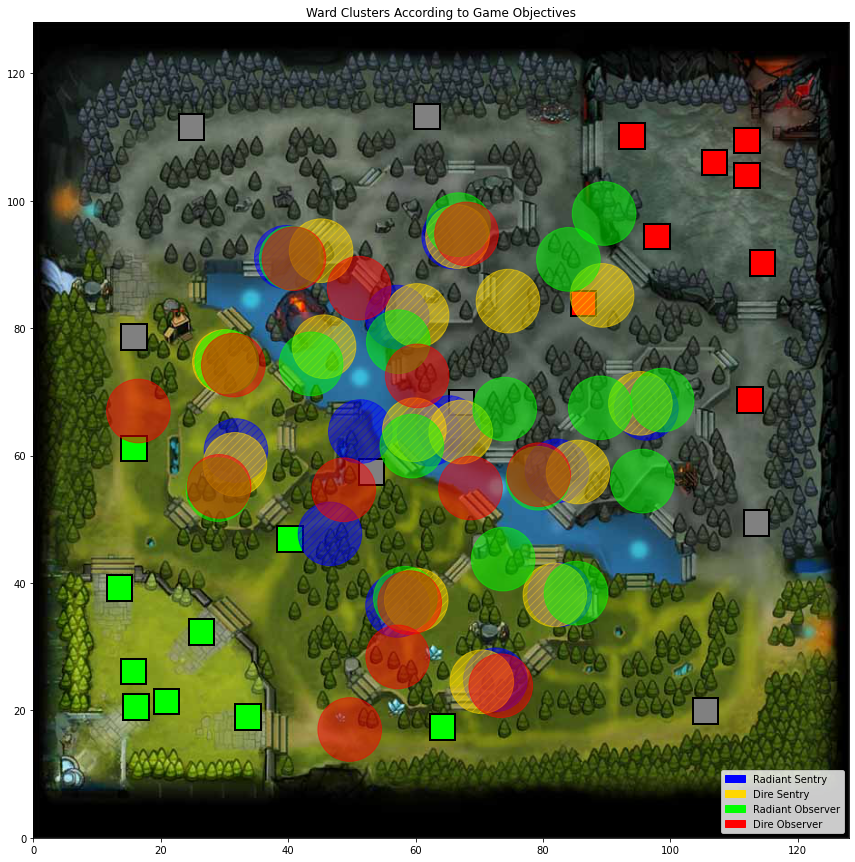

In [6]:
wards.plot_wards(save_path = os.path.join('tower_combos','test_map.png'),
                 show_plot=True)

In [7]:
#total number of combinations possible
# 4**6 = 4096
combos = (list(itertools.product([0, 1, 2, 3], repeat=6)))

In [8]:
combos[42]

(0, 0, 0, 2, 2, 2)

In [9]:
combos[4090]

(3, 3, 3, 3, 2, 2)

In [10]:
words = tuple((str(x) for x in combos[4090]))

In [11]:
'_'.join([a+b for a,b in zip(words, 'ABCDEF')])

'3A_3B_3C_3D_2E_2F'

In [12]:
combos.index((2,2,2,2,2,2))

2730

In [13]:
combos[2730]

(2, 2, 2, 2, 2, 2)

In [14]:
sample = (0,0,0,0,0,3)
wards.get_filtered_wards(*sample)
wards.fit_clusters()
wards.plot_wards(save_path = os.path.join('tower_combos','random_name.png'))

In [15]:
wards.valid_cluster_case

False

### Note: Case (0,0,0,0,0,0) takes the longest to run, especially if pre-game wards are included.

Rad Top = A <br>
Rad Mid = B <br>
Rad Bot = C <br>
Dir Top = D <br>
Dir Mid = E <br>
Dir Bot = F <br>


In [16]:
invalid_cases = []
for combo in tqdm(combos):
    #convert each element from int to string
    combo_string_tuple = tuple((str(x) for x in combo))
    #create code
    code = '_'.join([a+b for a,b in zip('ABCDEF', combo_string_tuple)])
    #convert to path to save to
    save_path = os.path.join('tower_combos',
                             ''.join([code,'.png'])
                            )
    
    #check if plot already exists to avoid duplicate work
    if not os.path.isfile(save_path):
        #get filtered data
        wards.get_filtered_wards(*combo)
        #fit to clusters
        wards.fit_clusters()
        #if the clusters are valid save the work
        if wards.valid_cluster_case:
            wards.plot_wards(save_path=save_path)
        #if not a valid case append to invalid list
        else:
            invalid_cases.append(code)
    
#at the end save the invalid cases to a text file
with open('invalid_cases.txt', 'w') as f:
    for item in invalid_cases:
        f.write("%s\n" % item)

100%|██████████| 4096/4096 [04:11<00:00, 16.27it/s]


In [17]:
df = wards.obs_data.copy(deep=True)
df.head()

match_id           start_time  hero_id  time   x   y    z  is_radiant  \
0  5972747514  2021-05-01 04:06:13      103   365  84  38  132           1   
1  5972747514  2021-05-01 04:06:13      103   592  68  30  130           1   
2  5972747514  2021-05-01 04:06:13      103   778  58  78  132           1   
3  5972747514  2021-05-01 04:06:13      103  1042  42  90  132           1   
4  5972747514  2021-05-01 04:06:13      103  1194  74  92  130           1   

   dire_tower1_top  radiant_tower1_bot  ...  radiant_range_rax_top  \
0            550.0               553.0  ...                10800.0   
1            550.0               553.0  ...                10800.0   
2            550.0               553.0  ...                10800.0   
3            550.0               553.0  ...                10800.0   
4            550.0               553.0  ...                10800.0   

   radiant_tower4  radiant_fort  ROSHAN_2  dire_tower4  ROSHAN_3  ROSHAN_4  \
0         10800.0       10800.0       NaN      10800.0       NaN       NaN   
1         10800.0       10800.0       NaN      10800.0       NaN       NaN   
2         10800.0       10800.0       NaN      10800.0       NaN       NaN   
3         10800.0       10800.0       NaN      10800.0       NaN       NaN   
4         10800.0       10800.0       NaN      10800.0       NaN       NaN   

   ROSHAN_5  ROSHAN_6  ROSHAN_7  
0       NaN       NaN       NaN  
1       NaN       NaN       NaN  
2       NaN       NaN       NaN  
3       NaN       NaN       NaN  
4       NaN       NaN       NaN  

[5 rows x 50 columns]

In [18]:
#7 times rosh?
df[df.ROSHAN_7.isna()==False].head(2)

match_id           start_time  hero_id  time    x   y    z  \
102617  6080190774  2021-07-09 09:03:58      128    -9   30  76  132   
102618  6080190774  2021-07-09 09:03:58      128   339  104  36  128   

        is_radiant  dire_tower1_top  radiant_tower1_bot  ...  \
102617           1            694.0               678.0  ...   
102618           1            694.0               678.0  ...   

        radiant_range_rax_top  radiant_tower4  radiant_fort  ROSHAN_2  \
102617                 2367.0          6231.0        6235.0    2708.0   
102618                 2367.0          6231.0        6235.0    2708.0   

        dire_tower4  ROSHAN_3  ROSHAN_4  ROSHAN_5  ROSHAN_6  ROSHAN_7  
102617       6195.0    3248.0    3880.0    4478.0    5076.0    5667.0  
102618       6195.0    3248.0    3880.0    4478.0    5076.0    5667.0  

[2 rows x 50 columns]

In [19]:
#planted somewhere 5min before roshing and right before killing rosh
df_rosh = df[((df['ROSHAN_1']-300) < df['time']) \
             &  (df['time']<df['ROSHAN_1'])]

#look at ssample
df_rosh.sample(10)[['time','ROSHAN_1']]


time  ROSHAN_1
80911   2341    2370.0
53936   1838    1992.0
98045   1751    1821.0
13466   1553    1716.0
73720   1532    1690.0
41538   2169    2221.0
2587    1713    1852.0
76641   1696    1841.0
110052  1921    2072.0
8108    1893    2189.0

In [20]:
avg_dead = np.mean(df_rosh['time'] > df_rosh['dire_tower2_top'])
avg_dead

0.5537912448102557

#### 1st Time Rosh

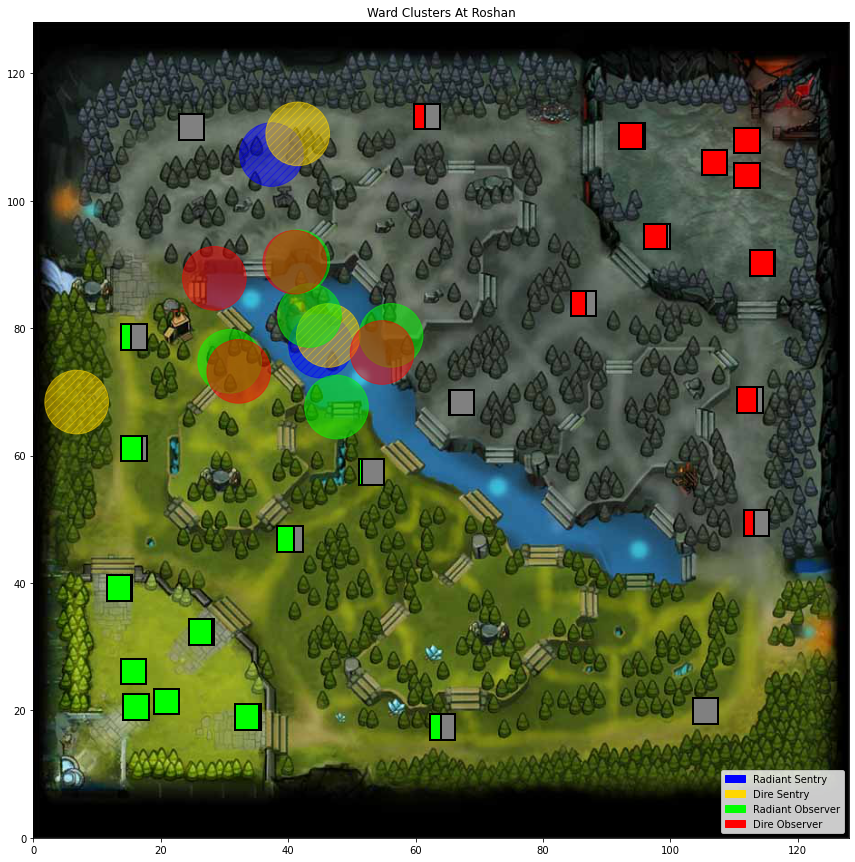

In [21]:
wards.get_rosh_clusters(rosh_attempt=1)
wards.plot_rosh_wards(save_path = os.path.join('tower_combos','rosh_attempt_01.png'), show_plot=True)

#### 2nd Time Rosh

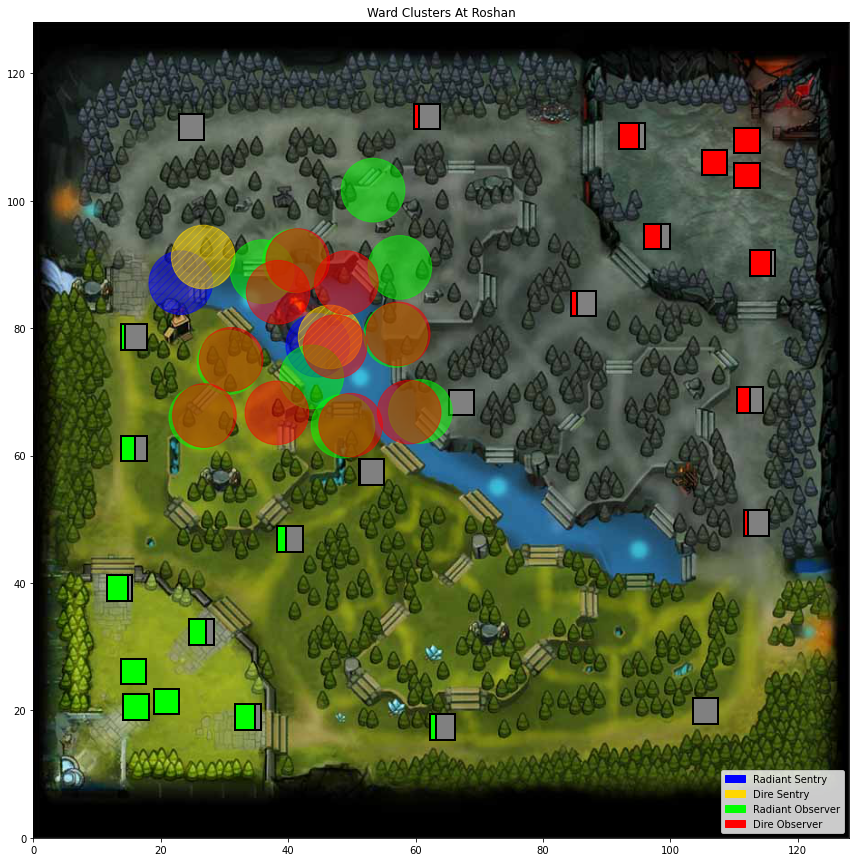

In [22]:
wards.get_rosh_clusters(rosh_attempt=2)
wards.plot_rosh_wards(save_path = os.path.join('tower_combos','rosh_attempt_02.png'), show_plot=True)

#### 3rd Time? 

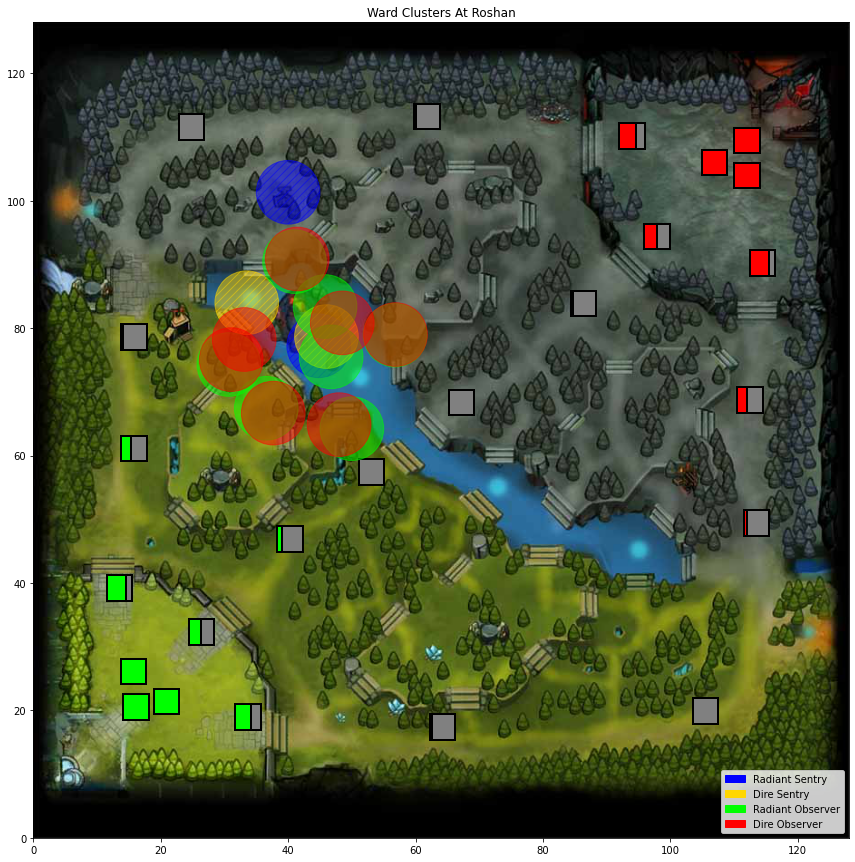

In [23]:
wards.get_rosh_clusters(rosh_attempt=3)
wards.plot_rosh_wards(save_path = os.path.join('tower_combos','rosh_attempt_03.png'), show_plot=True)